In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from typing import Annotated
from langgraph.graph import END
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = (
        f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    )
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [3]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [4]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState


llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # share internal message history of research agent with other agents
        "messages": result["messages"],
    }


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        # share internal message history of chart agent with other agents
        "messages": result["messages"],
    }

In [5]:
def router(state: MessagesState):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

In [6]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

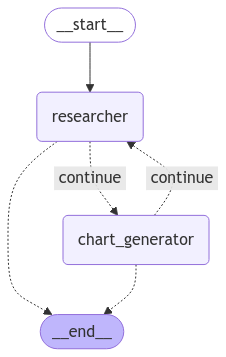

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='890b6ee0-eda8-4684-b34c-8efac2d09a16'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XMG9bAlsdNG7r7TPKdgKZQJy', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 208, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cbb71045-ba8d-4cc0-ba12-8616f2ca1d10-0', tool_calls=[{'nam

Python REPL can execute arbitrary code. Use with caution.


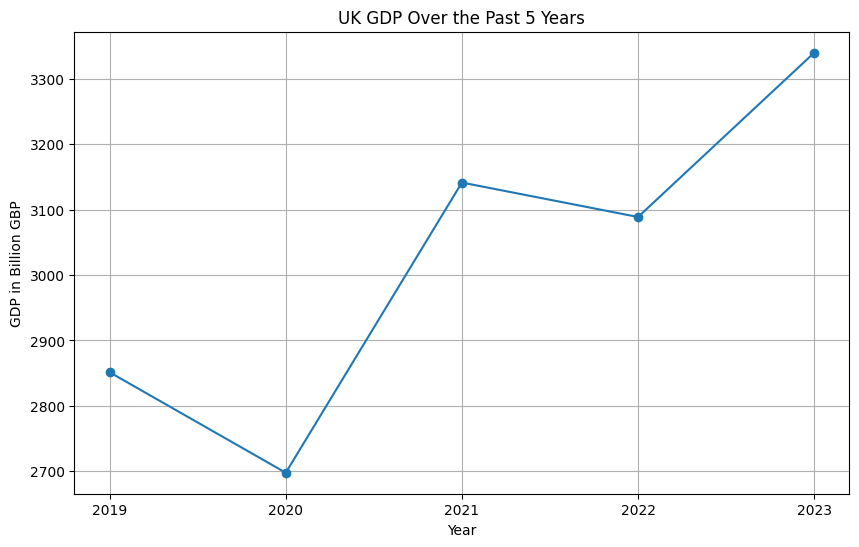

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='890b6ee0-eda8-4684-b34c-8efac2d09a16'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XMG9bAlsdNG7r7TPKdgKZQJy', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 208, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cbb71045-ba8d-4cc0-ba12-8616f2ca1d10-0', tool_calls=[

In [8]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")